In [1]:
import pandas as pd
import sqlite3

## 1

In [107]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

## 2

In [186]:
commits = pd.io.sql.read_sql(
    """
    SELECT timestamp
    FROM checker
    WHERE uid LIKE "user_%";
    """,
    con=conn, parse_dates=['timestamp']
)

In [187]:
commits[['day', 'hour']] = commits['timestamp'].apply(lambda x: pd.Series([x.date(), x.time().hour]))
commits = commits.drop(columns=['timestamp'])
commits['day'] = commits['day'].astype('datetime64[ns]')
commits['hour'] = pd.to_numeric(commits['hour'].values, downcast='integer')
commits['daytype'] = commits['day'].dt.dayofweek
commits['daytype'] = commits['daytype'].apply(lambda x: 'weekend' if x > 4 else 'working_day')

In [188]:
commits.sample(5)

,day,hour,daytype
1922,2020-05-12,6,working_day
2014,2020-05-12,16,working_day
2650,2020-05-14,16,working_day
2599,2020-05-14,15,working_day
1578,2020-05-09,22,weekend


In [238]:
working_days_info = commits[commits['daytype'] == 'working_day']
weekend_info = commits[commits['daytype'] == 'weekend']

In [239]:
working_days_info = working_days_info.groupby(by=['day', 'hour']).size().unstack()
weekend_info = weekend_info.groupby(by=['day', 'hour']).size().unstack()

In [240]:
working_days_info.head(1)

hour,0,3,5,6,7,8,9,10,11,12,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
2020-04-17,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,8.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
working_days_info = pd.DataFrame({'working_day': working_days_info.apply(lambda x: round(x.mean()))}).reset_index()
weekend_info = pd.DataFrame({'weekend': weekend_info.apply(lambda x: round(x.mean()))}).reset_index()

In [242]:
total_info = weekend_info.merge(working_days_info, on='hour', how='outer').set_index('hour')

In [243]:
total_info

,weekend,working_day
hour,,
0,2.0,3.0
1,6.0,NaN
3,1.0,2.0
5,2.0,8.0
6,NaN,2.0
7,4.0,5.0
8,7.0,4.0
9,4.0,6.0
10,7.0,13.0


array([<Axes: title={'center': 'weekend'}, xlabel='hour'>,
       <Axes: title={'center': 'working_day'}, xlabel='hour'>],
      dtype=object)

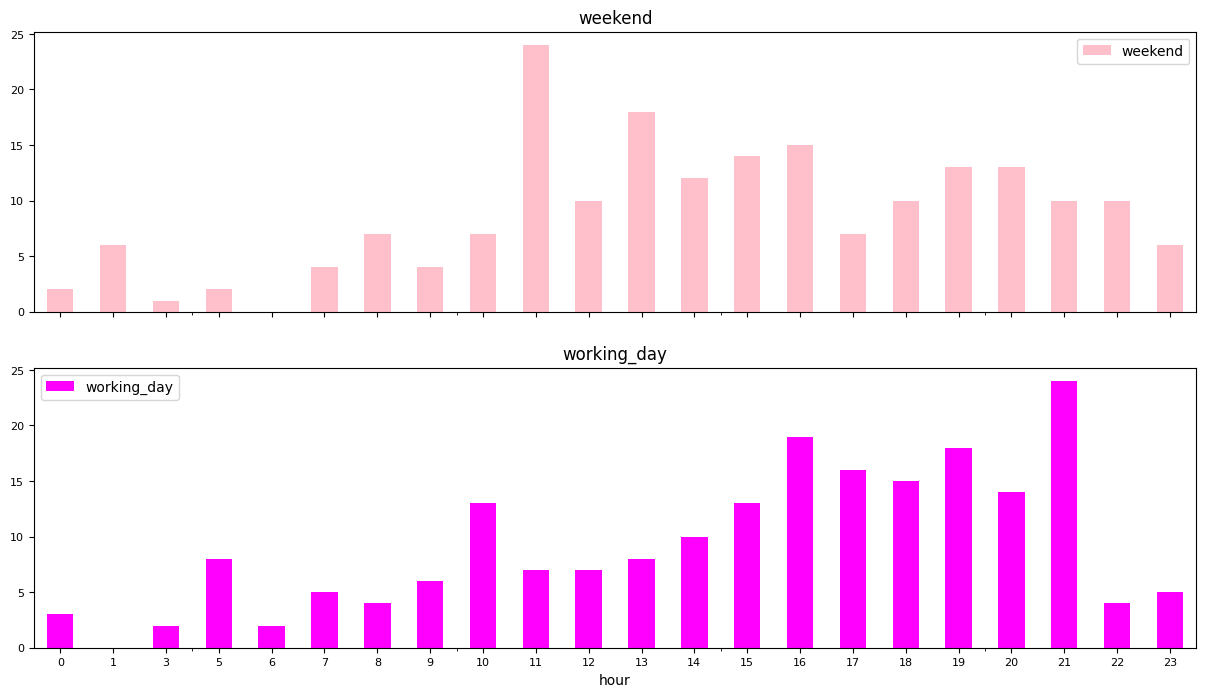

In [248]:
total_info.plot(kind='bar', fontsize=8, figsize=(15, 8), subplots=True, rot=0,
                color=['pink', 'magenta'])